# Format assertions for Neo4j ingestion
This notebook formats the filtered network for ingestion into the Neo4j database, which is necessary to run the KG UI. 

Also included is the option to plot histogram distributions of source edges, target edges, and edge significance in the unfiltered network. 

In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Format data for UI ingestion
This produces a nodes list that is compatible with the KG UI ingestion script. Nodes require two columns, id and label. Note that we only have one node type, Transcription Factor, so we only require one node file. Since the TF names are inherently unique, the TF name will be used for both fields. The KG UI edges require three fields: source, relation, and target. We have two relation types, upregulation and downregulation, so we need to produce two edge files. 

The file names for both the node and edge files are formatted to be compatible with the KG UI ingestion script and should not be changed.

Define the output directory for the formatted assertions

In [ ]:
assertions_dir = './kg_assertions_for_neo4j/test'

if not os.path.exists(assertions_dir):
    os.mkdir(assertions_dir)

Choose a network to format

In [ ]:
network_type = 'node_weighted'

Format nodes: [id,label]

In [ ]:
network_edge_file = f'./filtered_edge_list/{network_type}/edge_list_filtered.csv'
final_edge_list = pd.read_csv(network_edge_file)

# Set the label used to describe the node type
node_name = "Transcription Factor"

# collect all unique source and target nodes
nodes = set() 
for (source, target), group in final_edge_list.groupby(['source','target']):
    nodes.add((source, source))
    nodes.add((target, target))

node_df = pd.DataFrame(list(nodes), columns=['id', 'label'])
node_df.to_csv(f'{assertions_dir}/{node_name}.nodes.csv', index = False)

Reformat the edges: [source, relation, target] 

In [ ]:
# reorder the index to match ingestion format
new_order = ['source','relation','target']

reordered_df = final_edge_list[new_order]

# rename relations to be more descriptive
relation_rename = {
    '+': 'upregulates',
    '-': 'downregulates'
}

reordered_df['relation'] = reordered_df['relation'].replace(relation_rename)

# split the edge list based on relation type and save to two files
for relation in reordered_df['relation'].unique():
    filtered_df = reordered_df[reordered_df['relation'] == relation]
    file_name = f"{assertions_dir}/{node_name}.{relation}.{node_name}.edges.csv"
    filtered_df.to_csv(file_name, index=False)

## Histogram figures of source edge count, target edge count, and edge p-value distributions
By default, figures will be saves as PNGs. You can adjust the DPI or change the filetype to SVG below.

In [21]:
outputdir = 'summary_figures'
outputtype = 'png'
network_type = 'node_weighted'
path_to_network = f'./filtered_edge_list/{network_type}/z_sorted_edge_stats.csv'
dpi=300
figsize=(8,6)

if not os.path.exists(outputdir):
    os.makedirs(outputdir)

network = pd.read_csv(path_to_network, delimiter = '\t', usecols=['source', 'target', 'p-value'])

In [22]:
def plot_histogram(items, logbins, xlabel, ylabel, fig_name, ylog=False):
    fig, ax = plt.subplots(figsize=figsize)

    ax.hist(items, bins=logbins, color='black')

    ax.set_xscale('log')
    
    if ylog:
        ax.set_yscale('log')

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    plt.savefig(f'{outputdir}/{fig_name}.{outputtype}', dpi=dpi)
    plt.show()

Source edges per TF

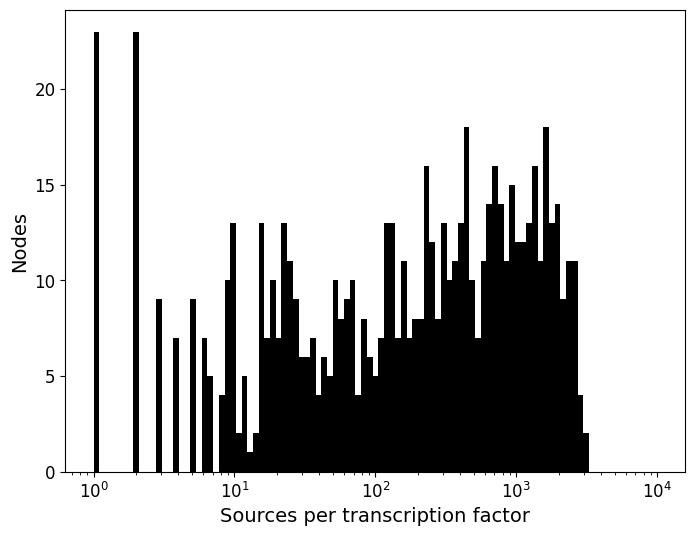

In [23]:
sources = network['source'].value_counts()
logbins = np.logspace(0,4,100)
plot_histogram(sources, logbins, "Sources per transcription factor", "Nodes", "source_histo")

Target edges per TF

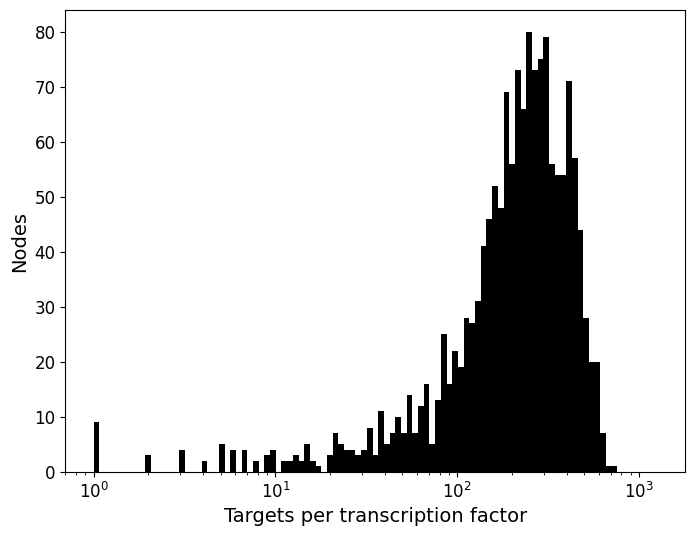

In [24]:
targets = network['target'].value_counts() 
logbins = np.logspace(0, 3.1,100)
plot_histogram(targets, logbins, "Targets per transcription factor", "Nodes", "target_histo")

Edge significance by p-value

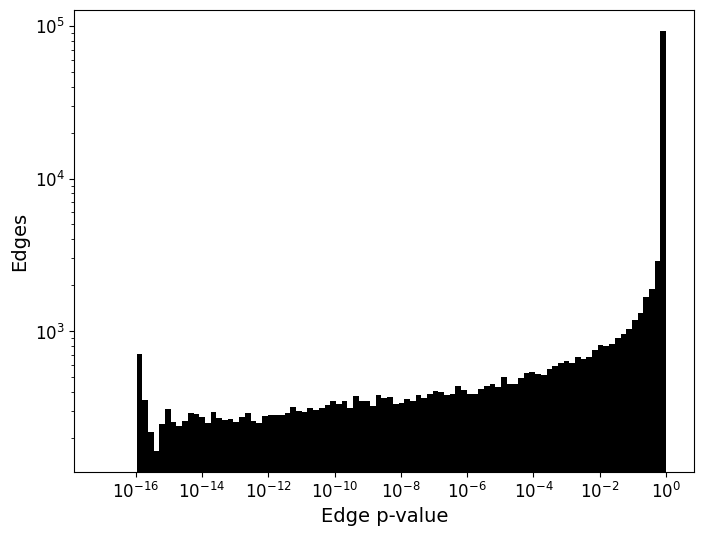

In [25]:
pvalue = network['p-value']
logbins = np.logspace(-17,0,100)
plot_histogram(pvalue, logbins, "Edge p-value", "Edges", "pvalue_histo", ylog=True)